In [ ]:
from pysr import PySRRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math

df_full = pd.read_excel("Figure4-Symbolic_Regression_Data.xlsx")

for col in df_full.columns:
    if df_full[col].dtype == object:
        df_full[col] = (
            df_full[col]
            .astype(str)
            .str.replace(",", ".", regex=False)
            .pipe(pd.to_numeric, errors="ignore")
        )

def clean_column(col):
    return re.sub(r"\W|^(?=\d)", "_", col)

df_full.columns = [clean_column(c) for c in df_full.columns]
mask_train = ~df_full["Name"].isin(["gRNA 6", "gRNA 7", "gRNA 1"])

df_train = df_full[mask_train].reset_index(drop=True)

# Features und Ziel
drop_cols = ["Name", "Sequence", "slowdown"]
feature_names = [c for c in df_full.columns if c not in drop_cols]

X_train = df_train[feature_names].values
y_train = df_train["slowdown"].values

X_full = df_full[feature_names].values
y_full = df_full["slowdown"].values

model = PySRRegressor(
    niterations=600,
    population_size=500,
    maxdepth=6,
    maxsize=8,
    binary_operators=["+", "-", "*", "/", "^"],
    unary_operators=["exp", "log", "sqrt"],
    elementwise_loss="(x, y) -> (x - y)^2",
    model_selection="best",
    turbo=True,
    deterministic=False,
    parallelism="multithreading",
    procs=6,
    timeout_in_seconds=600,
    verbosity=1,
    update_verbosity=500
)

model.fit(X_train, y_train, variable_names=feature_names)

with open("Equations.txt", "w") as f:
    for _, row in model.equations_.iterrows():
        f.write(f"Complexity {row['complexity']}, Loss {row['loss']:.5f}, Score {row['score']:.5f}\n")
        f.write(f"Equation: {row['sympy_format']}\n")
        f.write("-" * 80 + "\n")

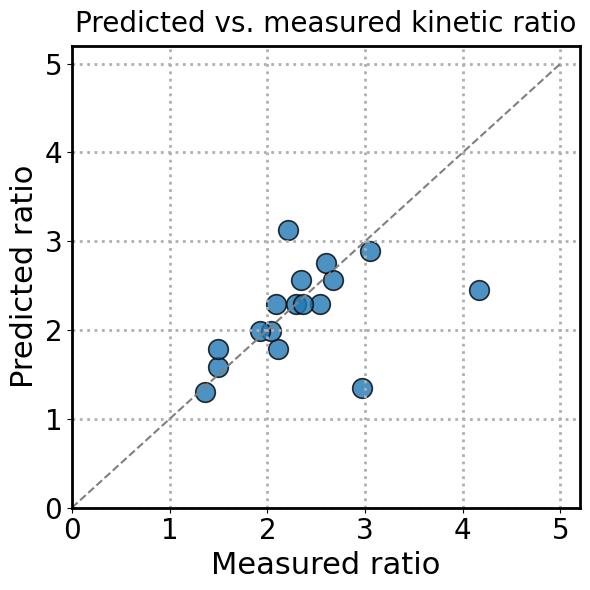

In [6]:
y_pred_full = model.predict(X_full)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.linewidth'] = 2  
plt.rcParams['figure.autolayout'] = False

fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(
    y_full, y_pred_full,
    s=200,
    alpha=0.8,
    edgecolor='k',
    linewidth=1.2
)

mn, mx = 0, 5
ax.plot([mn, mx], [mn, mx], '--', color='gray', linewidth=1.5, label="x = y")

ax.set_xlim(0, 5.2)
ax.set_ylim(0, 5.2)
ax.set_xlabel("Measured ratio", fontsize=22)
ax.set_ylabel("Predicted ratio", fontsize=22)
ax.set_title("Predicted vs. measured kinetic ratio", fontsize=20, pad=10)
ax.grid(True, linewidth=2, linestyle=':')
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

for spine in ax.spines.values():
    spine.set_linewidth(2)

plt.tight_layout()
plt.savefig("prediction_vs_Measurement.png", dpi=600)
plt.show()